# Lab. 7 - K-Means and the LLoyd algorithm

In this lab we consider the problem of **unsupervised learning**, through one of the most famous **clustering** algorithms: K-means.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy.linalg as la
import scipy.spatial

In [3]:
def mixGauss(means, sigmas, n):
    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels == 0] = -1

    return data, labels

In [4]:
def all_distances(X1, X2):
    return scipy.spatial.distance.cdist(X1, X2, metric='sqeuclidean')

## Part 1. Implementing the LLoyd Algorithm

The Lloyd algorithm is the standard algorithm for implementing k-means. It is based on two steps
 1. Assigning each point to a cluster
 2. Updating the cluster centers
repeated iteratively until the cluster centers (and point assignments) have converged.

The function skeleton below takes as input the following arguments
 - `X` the data matrix
 - `centers` the initial cluster centers. This could be random, or as we will see in the second part, they could be initialized following a smarter strategy.
 - `maxiter` the maximum number of iterations of the algorithm.
 
The function returns
 - the final cluster centers
 - the assignment labels of each point to their cluster.

In [5]:
def lloyd(X, centers, maxiter):
    # X: n x d
    # centers : k x d
    k, d = np.shape(centers)
    _ , dim = np.shape(X)    
        
    # check d == dim!
    assert(dim == d)

    for _ in np.arange(maxiter):
        # Compute Squared Euclidean distance (i.e. the squared distance)
        # between each cluster centre and each observation
        dist = all_distances(X, centers)
        # Assign data to clusters: 
        # for each point, find the minimum distance and the associated center
        c_asg = np.argmin(dist, axis=1)
        # Update cluster center
        for c in range(k):
            centers[c] = np.mean(X[c_asg == c], axis=0) 
        
    return c_asg, centers

## Part 2. K-Means: Analysis

Here you should create a synthetic dataset using the `mixGauss` function **with four or more classes**.

You can experiment with different dataset creation strategies:
 - Create datasets where the classes are very well separated, then k-means should be able to infer the classes easily
 - Create datasets where the classes have overlap. In this case the k-means algorithm won't be able to distinguish the points of overlap. What do you think will happen?
 
Then, you should run the k-means algorithm with randomly initialized centers:
 1. Create the random centers **within the same range as your data**. You can use the `np.random.uniform` function for this.
 2. Run the Lloyd algorithm
 3. Plot the results.

##### Your Tasks
You should repeat this procedure multiple times, and comment on the following:
 1. Do you obtain the same clusters every time?
     If you obtain clusterings which are always the same, you can try to initialize two cluster centers at a very similar point. This will put the algorithm in a difficult situation!
     
 2. Why do the colors of a specific cluster seem to change at each iteration?
 3. Try using the *wrong* number of clusters `k` (wrong with respect to the number of classes you used to generate the data). What happens?

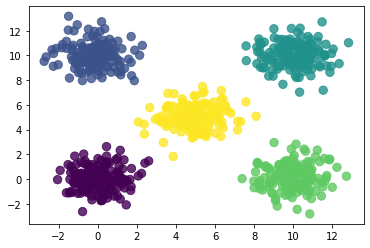

In [121]:
# Build a dataset with at least 4 classes in 2 dimensions, and plot it
means = [[0,0],[0,10],[10,10],[10,0],[5,5]]
sigmas = [1, 1, 1, 1, 1]
X, Y = mixGauss(means, sigmas, 150)
plt.scatter(X[:,0], X[:,1], s=70, c=Y, alpha=0.8)

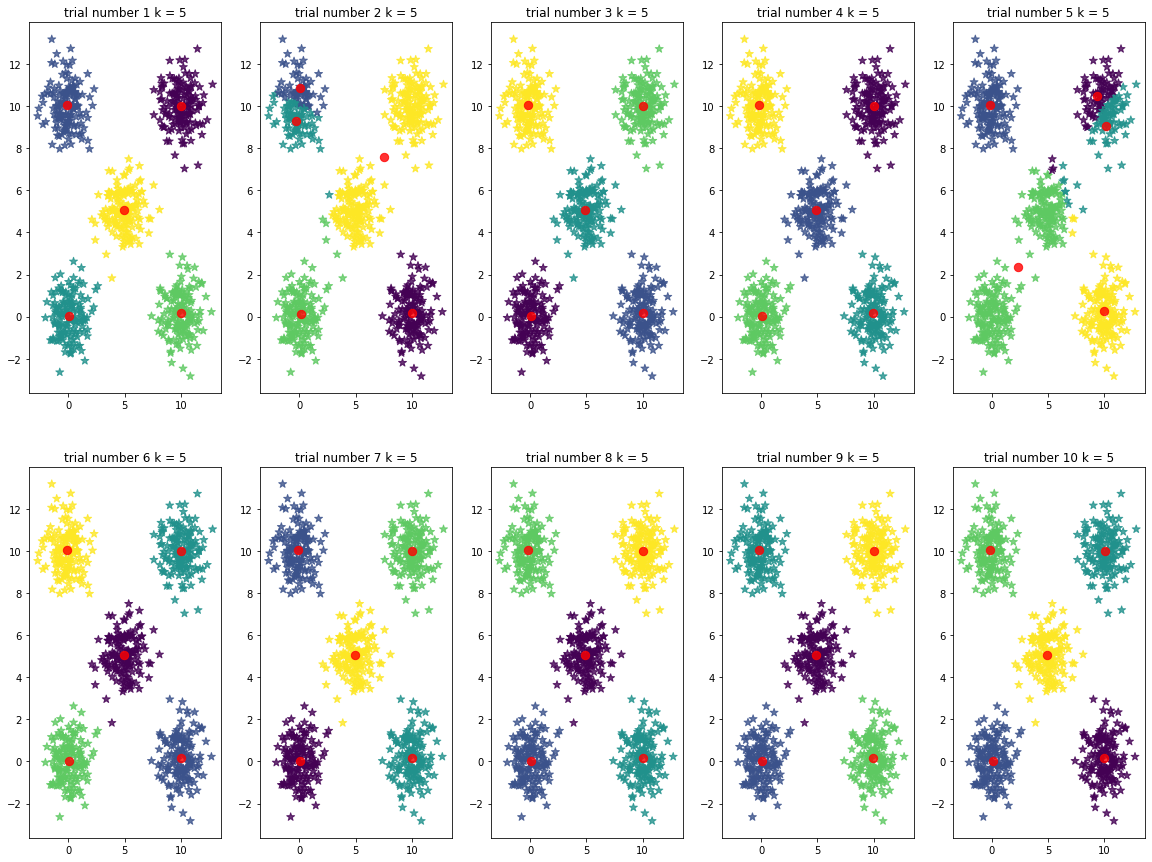

In [150]:

# number of trials
Tot = 10
# number of colums
Cols = 5

Rows = Tot // Cols 
Rows += Tot % Cols
# Create a Position index
Position = range(1,Tot + 1)

fig  = plt.figure(1)
fig.set_size_inches(20,15)


#choose k
k = 5

# Visualize the final clusters and their centroids

# NOTE: TRY MULTIPLE TIMES!
for n in range(Tot):
    ax = fig.add_subplot(Rows,Cols,Position[n]) 
    # randomly choose centers
    centers0 = np.random.uniform(low=np.amin(X, 0), high=np.amax(X, 0), size=(k, X.shape[1]))
    
    # call lloyd algo
    Iv, centers = lloyd(X, centers0, 10)

    ax.set_title(f"trial number {n+1} k = {k}")
    ax.scatter(X[:,0], X[:,1], s=70, c=Iv, marker='*',  alpha=0.8)
    ax.scatter(centers[:,0], centers[:,1], s=70, c='r', alpha=0.8)


# ANSWERS
---

## Putting clusters close together
  - the algorithm sometimes fail to recognize the right centroids if data overlap, even if the starting centroids chois is a "good" one!

## Colors change because of the initial centroids choise is *random*

  - We can clearly see from the plot how the algorithm sometimes settles into a state where one centroid is at the
    middle of 2 separeted clusters, and another cluster is splitted into 2 subclusters.

  - On some iterations the algorithm captures also some points from other distinct clusters we guess that's because 
    of the distance betwen datapoints/centroids.

## Usinig the wrong number **k**
  - when *k* is lower then the optimal one, the wwhole dataset is labelled in less clusters,  so there are less colors and less centers. The distance between datapoints and this "meaned" centroids determine the classification in k labels.
  - when "k" is higher, the data in cluster is destined to be splitted as new centroids act on the same euclidean space. The effect is the one we expect, having n cluster if we introduce a k=n+1 into the algorithm, 1 cluster is splitted in 2, if we introduce another one so k=n+2 whe observe different behaviours depending on the initial centroid setting but the majority of times 2 clusters are splitted and the other one are ell recognized.

## Part 3. A Better Initialization Strategy: K-Means++

Initializing the cluster centers at random, sometimes makes the algorithm converge to a sub-optimal local minimum.

The k-means++ algorithm is an **initialization strategy** to generate the initial centers, which can then be passed to the lloyd algorithm.

K-means++ works by selecting the cluster centers as the points within the dataset which have the **maximum distance** between each other. To do this it uses a greedy strategy implemented in the `kmeanspp` function below.

Take a look at the K-Means++ function and then use it as initialization for the K-means algorithm.

##### Your task:
You should take a dataset on which K-Means was struggling, and apply K-Means++ for the center initialization, trying to show that the new initialization strategy improves the clustering algorithm.

In [133]:
def kmeanspp(X, k):
    n, d = X.shape

    IdxC = np.random.permutation(n)
    centers = np.zeros((k, d))

    # Select a random point in the dataset as the starting point
    centers[0, :] = X[IdxC[0], :]

    for i in range(1, k):
        D = all_distances(centers[:i, :], X)
        Ds = np.min(D, axis=0)  # This is the distance to the closest existing center

        # Probability of choosing new points as centers is weighted as the 
        # squared distance to the closest existing center.
        D2 = Ds ** 2
        P = np.divide(D2, np.sum(D2))
        
        # Simply pick the point with the highest probability
        newcpos = np.argmax(P)
        centers[i,:] = X[newcpos, :]
    return centers

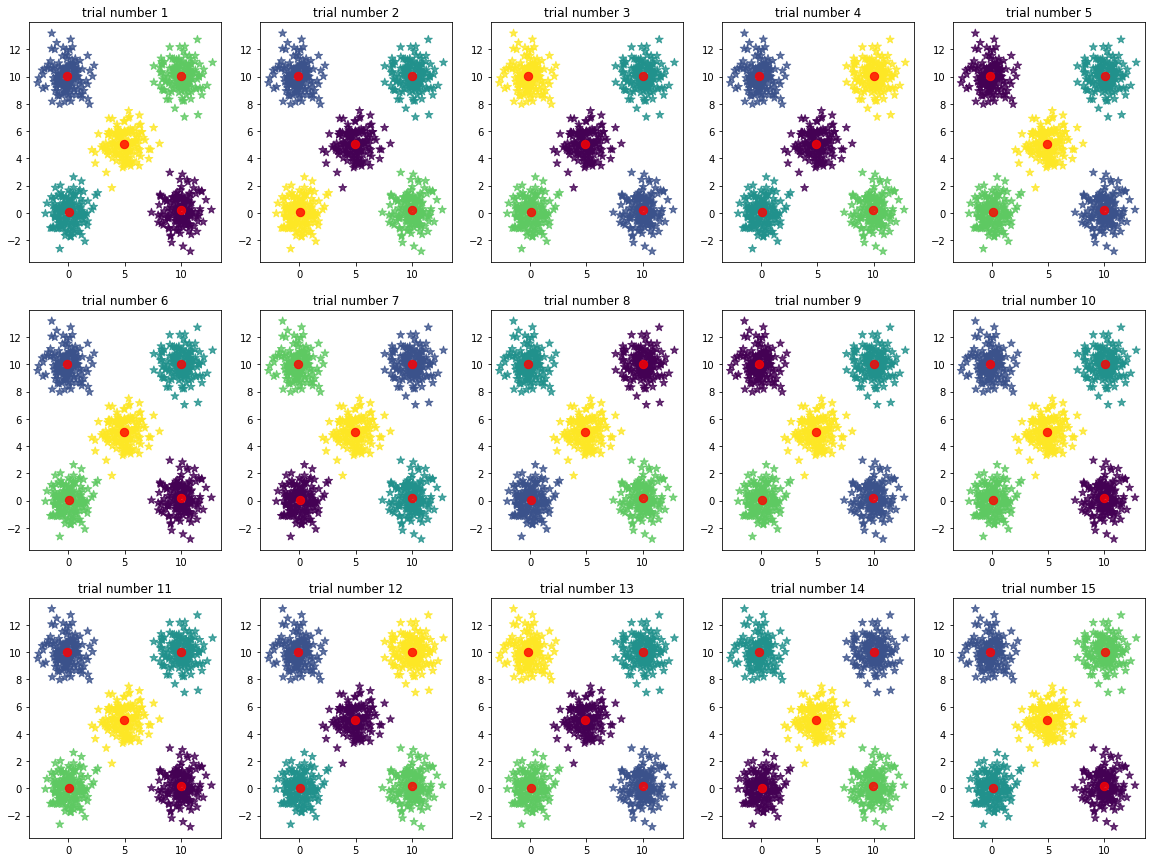

In [135]:
# number of trials
Tot = 15

# number of colums
Cols = 5

k = 5

# Visualize the final clusters and their centroids
#compute rows
Rows = Tot // Cols 
Rows += Tot % Cols
# Create a Position index
Position = range(1,Tot + 1)

fig  = plt.figure(1)
fig.set_size_inches(20,15)

for n in range(Tot):
    ax = fig.add_subplot(Rows,Cols,Position[n]) 
    # randomly choose centers
    centers0 = kmeanspp(X,k)
    
    # call lloyd algo
    Iv, centers = lloyd(X, centers0, 10)
   
    ax.set_title(f"trial number {n+1}")
    ax.scatter(X[:,0], X[:,1], s=70, c=Iv, marker='*',  alpha=0.8)
    ax.scatter(centers[:,0], centers[:,1], s=70, c='r', alpha=0.8)

# OBSERVATIONS

---

We can see how a good choice of the first centroids affects the final result of the cathegorization in this unsupervised setting. This heuristic is particurally effective in cases when noise and close data clusters
 